In [1]:
import math
from tqdm import tqdm
import torch
import torch.distributions as distributions
import seaborn as sns
import matplotlib.pyplot as plt

LOG_EPSILON = 1e-39

/Users/fdi/opt/anaconda3/envs/universal_gnn/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def remove_outliers_with_std(x):
    mean, std = torch.mean(x), torch.std(x)
    threshold = 3
    outlier_indices = torch.abs(x - mean) > threshold * std
    x = x[~outlier_indices]
    return x

def remove_outliers_with_tukey_fences(x):
    q1, q3 = torch.quantile(x, torch.tensor([0.25, 0.75]))
    iqr = q3 - q1
    f1 = q1 - 1.5*iqr
    f2 = q3 + 1.5*iqr
    outliers_indices = torch.logical_or(x < f1, x > f2)
    x = x[~outliers_indices]
    return x

def create_distribution(x, min, max, n_bins=10000):
    histogram = torch.histc(x, bins=n_bins, min=min, max=max)
    distribution = histogram / torch.sum(histogram)
    return distribution
    
def compute_js_divergence(p, q):
    part1 = torch.sum(p * torch.log2(2.0 * p + LOG_EPSILON) - p * torch.log2(p + q + LOG_EPSILON))
    part2 = torch.sum(q * torch.log2(2.0 * q + LOG_EPSILON) - q * torch.log2(q + p + LOG_EPSILON))
    return 0.5 * part1 + 0.5 * part2

def plot_scores(scores, x_label, y_label, path, show=False):
    indices = [i for i in range(len(scores))]
    fig, ax = plt.subplots()
    sns.set(style='darkgrid')
    ax.bar(indices, scores, edgecolor="none")
    ax.set(xlabel=x_label, ylabel=y_label)
    plt.tight_layout()
    plt.savefig(path)
    if show:
        plt.show()
    plt.close()

def plot_heatmap(x, x_label, y_label, path, show=False):
    annot = True
    if x.shape[0] > 20 or x.shape[1] > 20:
        annot = False
    ax = sns.heatmap(x.numpy(), annot=annot)
    sns.set(style='darkgrid')
    ax.set(xlabel=x_label, ylabel=y_label)
    plt.tight_layout()
    plt.savefig(path)
    if show:
        plt.show()
    plt.close()

In [3]:
def simb_score(dataset, n_bins=10000, features_to_skip=[], device='cpu'):
    n_features = dataset.shape[1]
    js_divergences = []
    uniform_distribution = torch.ones(n_bins).to(device) / n_bins

    for feature in tqdm(range(n_features)):
        if feature in features_to_skip:
            continue
        dataset_slice = dataset[:, feature]
        dataset_slice = remove_outliers_with_tukey_fences(dataset_slice)
        min, max = torch.min(dataset_slice), torch.max(dataset_slice)
        distribution = create_distribution(dataset_slice, min, max, n_bins=n_bins)
        js_divergence= compute_js_divergence(distribution, uniform_distribution)
        js_divergences.append(js_divergence)
    
    js_divergences = torch.tensor(js_divergences).to(device)
    simb_score = torch.mean(js_divergences)
    return simb_score, js_divergences


In [4]:
def stood_score(train_set, validation_set, test_set, n_bins=10000, features_to_skip=[], device='cpu'):
    n_features = train_set.shape[1]
    js_divergences_validation, js_divergences_test = [], []

    for feature in tqdm(range(n_features)):
        if feature in features_to_skip:
            continue
        train_slice = train_set[:, feature]
        validation_slice = validation_set[:, feature]
        test_slice = test_set[:, feature]

        train_slice = remove_outliers_with_tukey_fences(train_slice)
        validation_slice = remove_outliers_with_tukey_fences(validation_slice)
        test_slice = remove_outliers_with_tukey_fences(test_slice)

        slice = torch.cat((train_slice, validation_slice, test_slice), dim=0)
        min, max = torch.min(slice), torch.max(slice)

        train_distribution = create_distribution(train_slice, min, max, n_bins=n_bins)
        validation_distribution = create_distribution(validation_slice, min, max, n_bins=n_bins)
        test_distribution = create_distribution(test_slice, min, max, n_bins=n_bins)

        js_divergence_validation = compute_js_divergence(train_distribution, validation_distribution)
        js_divergence_test = compute_js_divergence(train_distribution, test_distribution)

        js_divergences_validation.append(js_divergence_validation)
        js_divergences_test.append(js_divergence_test)
    
    js_divergences_validation = torch.tensor(js_divergences_validation).to(device)
    js_divergences_test = torch.tensor(js_divergences_test).to(device)

    stood_score_val = torch.mean(js_divergences_validation)
    stood_score_test = torch.mean(js_divergences_test)
    return stood_score_val, stood_score_test, js_divergences_validation, js_divergences_test

In [5]:
def outlier_score(dataset, features_to_skip=[], device='cpu'):
    n_features = dataset.shape[1]
    outlier_subscores = []

    for feature in tqdm(range(n_features)):
        if feature in features_to_skip:
            continue
        dataset_slice = dataset[:, feature]
        q1, q3 = torch.quantile(dataset_slice, torch.tensor([0.25, 0.75]))
        iqr = q3 - q1
        f1 = q1 - 1.5*iqr
        f2 = q3 + 1.5*iqr
        e1 = q1 - 3*iqr
        e2 = q3 + 3*iqr
        extreme_outliers_indices = torch.logical_or(dataset_slice <= e1, dataset_slice >= e2)
        left_outliers_indices = torch.logical_or(dataset_slice <= f1, dataset_slice >= e1)
        right_outliers_indices = torch.logical_or(dataset_slice <= e2, dataset_slice >= f2)
        extreme_outliers_scores = dataset_slice[extreme_outliers_indices]
        left_outliers_scores = dataset_slice[left_outliers_indices]
        right_outliers_scores = dataset_slice[right_outliers_indices]
        extreme_outliers_scores[:] = 1
        left_outliers_scores = (left_outliers_scores - e1)/(f1 - e1)
        right_outliers_scores = (right_outliers_scores - f2)/(e2 - f2)
        outliers_scores_sum = extreme_outliers_scores.sum() + left_outliers_scores.sum() + right_outliers_scores.sum()
        outliers_scores_len = extreme_outliers_scores.shape[0] + left_outliers_scores.shape[0] + right_outliers_scores.shape[0]
        outlier_subscore = outliers_scores_sum/outliers_scores_len
        outlier_subscores.append(outlier_subscore)
        
    outlier_subscores = torch.tensor(outlier_subscores).to(device)
    outlier_score = torch.mean(outlier_subscores)
    return outlier_score, outlier_subscores


In [6]:
def io_score(features, labels, features_to_skip=[], device='cpu'):
    n_features = features.shape[1]
    n_labels = labels.shape[1]
    mean_deltas = torch.zeros(n_features - len(features_to_skip), n_labels).to(device)

    for feature in tqdm(range(n_features)):
        slice = torch.hstack((features[:, feature].unsqueeze(1), labels))
        sorted_indices = slice[:, 0].sort()[1]
        slice = slice[sorted_indices]
        for label in range(n_labels):
            label_slice = slice[:, label + 1]
            feature_slice = slice[:, 0]
            delta_label = label_slice[1:] - label_slice[:-1]
            delta_feature = feature_slice[1:] - feature_slice[:-1]
            delta = delta_label/delta_feature
            delta = delta[~torch.isnan(delta) & ~torch.isinf(delta)]
            delta = torch.arctan(torch.abs(delta))/(math.pi/2)
            delta = delta[~torch.isnan(delta) & ~torch.isinf(delta)]
            mean_delta = torch.mean(delta)
            mean_deltas[feature][label] = mean_delta
        
    io_score = mean_deltas.mean()
    return io_score, mean_deltas

 11%|█         | 130/1200 [00:00<00:01, 594.68it/s]

100%|██████████| 1200/1200 [00:01<00:00, 670.31it/s]


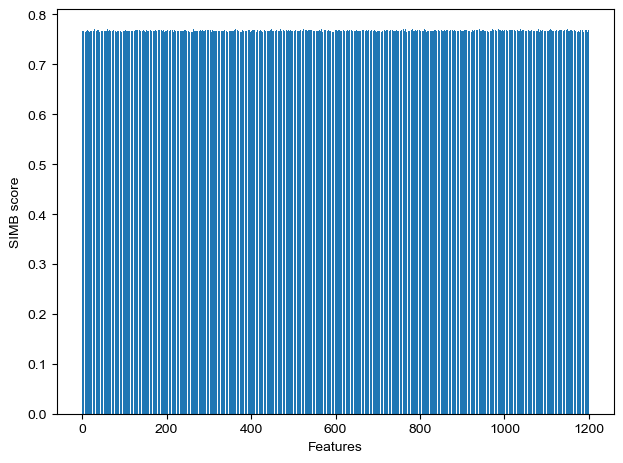

SIMB score: 0.7676836848258972


In [7]:
dist = distributions.uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))

data_set = dist.sample(sample_shape=(1000, 1200))

simb_score_value, js_divergences = simb_score(data_set)
plot_scores(js_divergences, "Features", "SIMB score", "SIMB_scores.svg", show=True)
print("SIMB score:", simb_score_value.item())

100%|██████████| 30/30 [00:05<00:00,  5.75it/s]


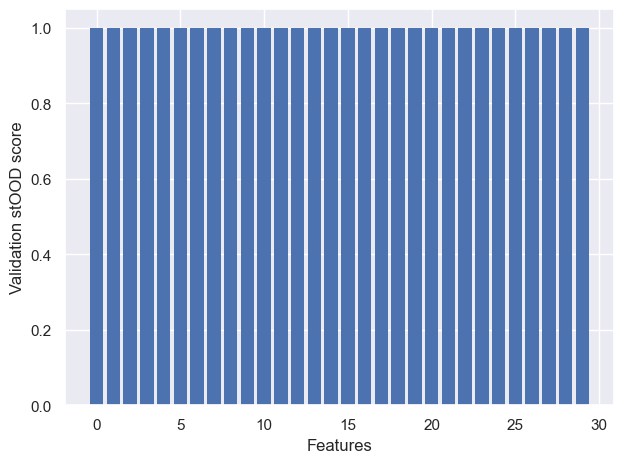

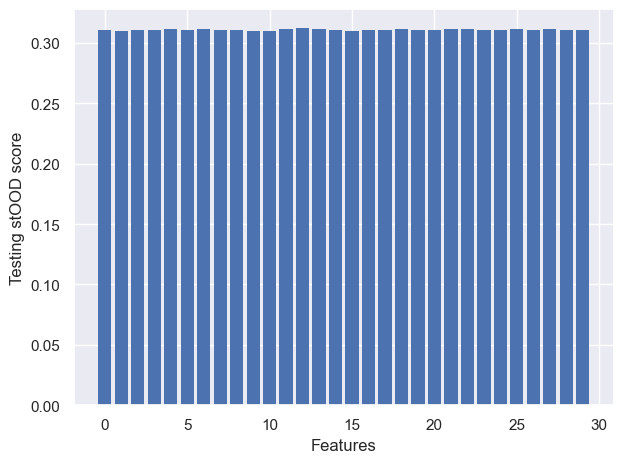

Validation stOOD score:  1.0
Testing stOOD score: 0.31081825494766235


In [8]:
train_dist = distributions.uniform.Uniform(torch.tensor([30.0]), torch.tensor([40.0]))
val_dist = distributions.normal.Normal(torch.tensor([50.0]), torch.tensor([2.0]))
test_dist = distributions.uniform.Uniform(torch.tensor([25.0]), torch.tensor([45.0]))

train_set = train_dist.sample(sample_shape=(400000, 30))
val_set = val_dist.sample(sample_shape=(100000, 30))
test_set = test_dist.sample(sample_shape=(500000, 30))


stood_score_val, stood_score_test, js_divergences_validation, js_divergences_test = stood_score(train_set, val_set, test_set, n_bins=1000)
plot_scores(js_divergences_validation, 'Features', 'Validation stOOD score', "stOOD_score_val.svg", show=True)
plot_scores(js_divergences_test, 'Features', 'Testing stOOD score', "stOOD_score_test.svg", show=True)
print("Validation stOOD score: ", stood_score_val.item())
print("Testing stOOD score:", stood_score_test.item())

  0%|          | 0/1200 [00:00<?, ?it/s]

100%|██████████| 1200/1200 [00:00<00:00, 1851.69it/s]


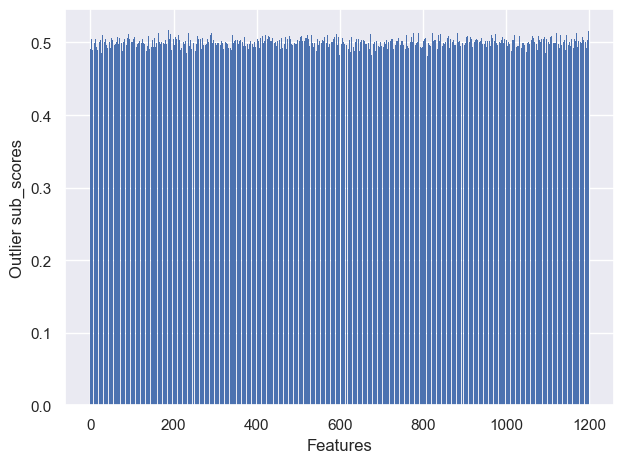

Outlier score: 0.5002092719078064


In [9]:
dist = distributions.uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))

data_set = dist.sample(sample_shape=(1000, 1200))

outlier_score_value, outlier_subscores = outlier_score(data_set)
plot_scores(outlier_subscores, "Features", "Outlier sub_scores", "Outlier_scores.svg", show=True)
print("Outlier score:", outlier_score_value.item())

100%|██████████| 1/1 [00:00<00:00, 446.63it/s]


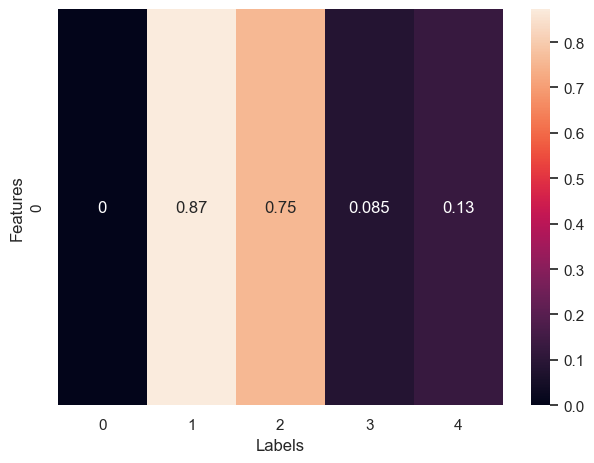

IOS score:  0.36761489510536194


In [10]:
x = torch.linspace(0, 10, 100).unsqueeze(1)
y_1 = 0*x
y_2 = x**2
y_3 = torch.sin(x**2)
y_4 = torch.arctan(x)
y_5 = 1/x
data = torch.hstack((x,y_1, y_2, y_3, y_4, y_5))

simb_score_daje, js_divergences = io_score(data[:, 0].unsqueeze(1), data[:, 1:])
plot_heatmap(js_divergences, 'Labels', 'Features', "simb_score_heatmap.svg", show=True)
print("IOS score: ", simb_score_daje.item())